In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release-20160523/bin'
#PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
#PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = '/scratch/SuperResolution/BRAINSSuperResolution/HCPWorkflows/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

PYTHON_AUX_PATHS = '/scratch/wmql/tract_querier/tract_querier/:/scratch/wmql/tract_querier/tract_querier/nipype/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

In [3]:
from tractography import Tractography, tractography_to_file, tractography_from_files
import numpy as np

In [4]:
# gs: gold standard
# in: input
gs_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/Baseline_query_cst.left.vtp'
gs_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/Baseline_query_cst.right.vtp'

sr_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/WTV_query_cst.left.vtp'
sr_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/WMQL/WTV_query_cst.right.vtp'

In [5]:
tractography = tractography_from_files(gs_cst_left_fn)
tracts = tractography.tracts()

In [6]:
import pandas as pd
from ggplot import *

/IPLlinux/raid0/homes/aghayoor/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


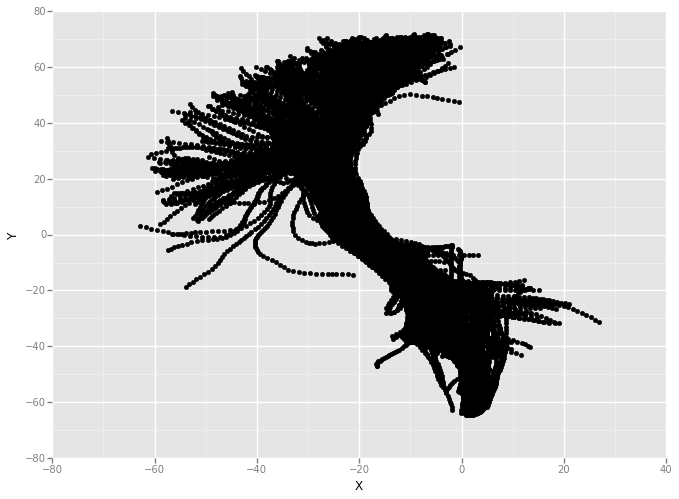

<ggplot: (316119205)>

In [7]:
pts = np.vstack(tracts)

DF_gs_x = pd.DataFrame(np.transpose([pts[:,0], pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

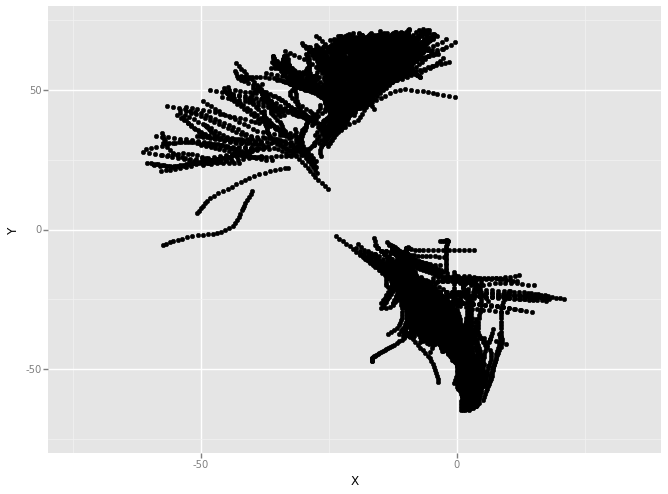

<ggplot: (329887625)>

In [8]:
tracts_last_quarter = [tracts[i][4*len(tracts[i])/5:] for i in xrange(len(tracts))]
pts = np.vstack(tracts_last_quarter)

DF_gs_x = pd.DataFrame(np.transpose([pts[:,0], pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point() \
    + xlim(-80, 40) \
    + ylim(-80, 80)

# Return bundle points

In [13]:
def AlignFiber(tract):
    out_tract = tract
    vecs = np.diff(tract, axis=0)
    avg_vec = np.mean(vecs, axis=0)
    dots = np.array([ np.dot(avg_vec,[1,0,0]), np.dot(avg_vec,[0,1,0]), np.dot(avg_vec,[0,0,1]) ])
    idx = np.argmax(np.abs(dots))
    if (dots[idx] < 0):
        out_tract = tract[::-1]
    return out_tract

def InterpolateFiber(tract):
    new_tract = tract
    # find point distances
    d = np.diff(tract, axis=0)
    pointdists = np.hypot(d[:,0], d[:,1], d[:,2])
    dist_threshold = min(pointdists.sum()/len(pointdists),1)
    offset = 0
    for i in xrange(len(pointdists)):
        if pointdists[i] > dist_threshold:
            new_p = (tract[i+1]+tract[i])/2
            new_tract = np.insert(new_tract,i+1+offset,new_p,axis=0)
            offset += 1
    return new_tract

def returnBundlePoints(bundle):
    tractography = tractography_from_files(bundle)
    tracts = tractography.tracts()
    ## sort all tracts direction to positive coordinate of their dominant orientation
    ## then interpolate tracts to make sure they are approximately equally placed
    for i in xrange(len(tracts)):
        tracts[i] = AlignFiber(tracts[i])
        tracts[i] = InterpolateFiber(tracts[i])
    #
    tracts_last_quarter = [tracts[i][9*len(tracts[i])/10:] for i in xrange(len(tracts))]
    #
    pts = np.vstack(tracts)
    pts_last_quarter = np.vstack(tracts_last_quarter)
    return pts, pts_last_quarter

In [14]:
[pts, pts_last_quarter] = returnBundlePoints(gs_cst_left_fn)

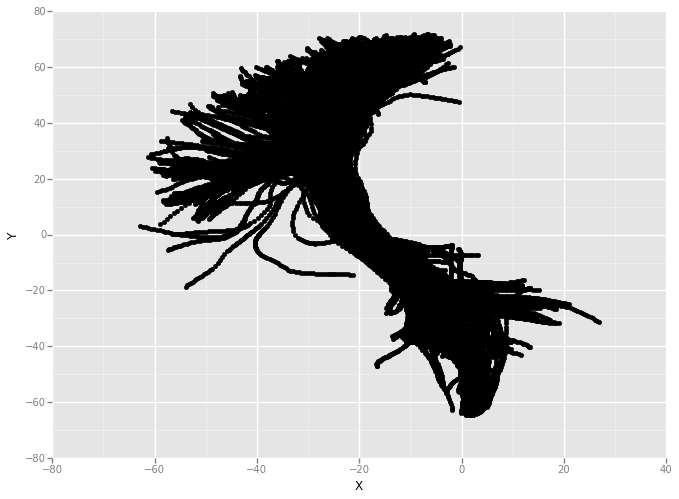

<ggplot: (328145025)>

In [15]:
DF_gs_x = pd.DataFrame(np.transpose([pts[:,0], pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

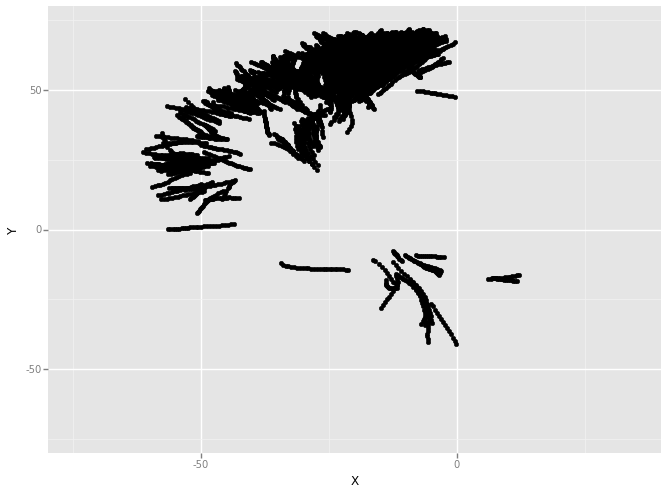

<ggplot: (328121505)>

In [16]:
pts = pts_last_quarter

DF_gs_x = pd.DataFrame(np.transpose([pts[:,0], pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point() \
    + xlim(-80, 40) \
    + ylim(-80, 80)